# Authorship prediction with the author-topic model

In this tutorial, you will learn how to use the author-topic model in Gensim for authorship prediction, based on the topic distributions and mesuring their similarity.
We will train the author-topic model on a Reuters dataset, which contains 50 authors, each with 50 documents for trianing and another 50 documents for testing: https://archive.ics.uci.edu/ml/datasets/Reuter_50_50 .

If you wish to learn more about the Author-topic model and LDA and how to train them, you should check out these tutorials beforehand. A lot of the preprocessing and configuration here has been done using their example:
* [LDA training tips](https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/lda_training_tips.ipynb)
* [Training the author-topic model](https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb)

> **NOTE:**
>
> To run this tutorial on your own, install Jupyter, Gensim, SpaCy, Scikit-Learn, Bokeh and Pandas, e.g. using pip:
>
> `pip install jupyter gensim spacy sklearn bokeh pandas`
>
> Note that you need to download some data for SpaCy using `python -m spacy.en.download`.
>
> Download the notebook at https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks/atmodel_prediction_tutorial.ipynb.


Predicting the author of a document is a difficult task, where current approaches usually turn to neural networks. These base a lot of their predictions on learing stylistic and syntactic preferences of the authors and also other features which help rather identify the author. 

In our case, we first model the domain knowledge of a certain author, based on what the author writes about. We do this by calculating the topic distributions for each author using the author-topic model.
After that, we perform the [new author inference](https://github.com/RaRe-Technologies/gensim/pull/1766) on the held-out subset. This again calculates a topic distribution for this new unknown author. 
In order to perform the prediction, we find out of all known authors, the most similar one to the new unknown. Mathematically speaking, we find the author, whose topic distribution is the closest to the topic distribution of the new author, by a certrain distrance function or metric. 
Here we explore the [Hellinger distance](https://en.wikipedia.org/wiki/Hellinger_distance) for the measuring the distance between two discrete multinomial topic distributions.

We start off by downloading the dataset. You can do it manually using the aforementioned link, or run the following code cell.

In [1]:
!wget -O - "https://archive.ics.uci.edu/ml/machine-learning-databases/00217/C50.zip" > /tmp/C50.zip

--2018-03-25 17:24:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00217/C50.zip
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8194031 (7.8M) [application/zip]
Saving to: 'STDOUT'

-                   100%[===================>]   7.81M  2.30MB/s    in 3.4s    

2018-03-25 17:24:31 (2.30 MB/s) - written to stdout [8194031/8194031]



In [2]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [3]:
import zipfile

filename = '/tmp/C50.zip'

zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall("/tmp/")
zip_ref.close()

We wrap all the preprocessing steps, that you can find more about in the [author-topic notebook](https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb) , in one fucntion so that we are able to iterate over different preprocessing parameters.

In [4]:
import os, re, io
def preprocess_docs(data_dir):
    doc_ids = []
    author2doc = {}
    docs = []
    
    folders = os.listdir(data_dir)  # List of filenames.
    for authorname in folders:
        files = file = os.listdir(data_dir + '/' + authorname)
        for filen in files:
            (idx1, idx2) = re.search('[0-9]+', filen).span()  # Matches the indexes of the start end end of the ID.
            if not author2doc.get(authorname):
                # This is a new author.
                author2doc[authorname] = []
            doc_id = str(int(filen[idx1:idx2]))
            doc_ids.append(doc_id)
            author2doc[authorname].extend([doc_id])

            # Read document text.
            # Note: ignoring characters that cause encoding errors.
            with io.open(data_dir + '/' + authorname + '/' + filen, errors='ignore', encoding='utf-8') as fid:
                txt = fid.read()

            # Replace any whitespace (newline, tabs, etc.) by a single space.
            txt = re.sub('\s', ' ', txt)
            docs.append(txt)
            
    doc_id_dict = dict(zip(doc_ids, range(len(doc_ids))))
    # Replace dataset IDs by integer IDs.
    for a, a_doc_ids in author2doc.items():
        for i, doc_id in enumerate(a_doc_ids):
            author2doc[a][i] = doc_id_dict[doc_id]
    import spacy
    nlp = spacy.load('en')
    
    %%time
    processed_docs = []
    for doc in nlp.pipe(docs, n_threads=4, batch_size=100):
        # Process document using Spacy NLP pipeline.

        ents = doc.ents  # Named entities.

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list.
        #doc = [token for token in doc if token not in STOPWORDS]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])
        processed_docs.append(doc)
    docs = processed_docs
    del processed_docs
    
    # Compute bigrams.

    from gensim.models import Phrases

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs, author2doc

We create the corpus of the train and test data using two separate functions, since each corpus is tied to a certain dictionary which maps the words to their ids. Also in order to create the test corpus, we use the dictionary from the train data, since the trained model has have the same id2word reference as the new test data. Otherwise token with id 1 from the test data wont't mean the same as the trained upon token with id 1 in the model.

In [5]:
def create_corpus_dictionary(docs, max_freq=0.5, min_wordcount=20):
    # Create a dictionary representation of the documents, and filter out frequent and rare words.
    from gensim.corpora import Dictionary
    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = max_freq
    min_wordcount = min_wordcount
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    _ = dictionary[0]  # This sort of "initializes" dictionary.id2token.

    # Vectorize data.
    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary

def create_test_corpus(train_dictionary, docs):
    # Create test corpus using the dictionary from the train data.
    return [train_dictionary.doc2bow(doc) for doc in docs]

For our first training, we specify that we want the parameters max_freq and min_wordcoun to be 50 and 20, as proposed by the original notebook tutorial. We will find out if this configuration is good enough for us.

In [6]:
traindata_dir = "/tmp/C50train"
train_docs, train_author2doc = preprocess_docs(traindata_dir)
train_corpus_50_20, train_dictionary_50_20 = create_corpus_dictionary(train_docs, 0.5, 20)

05:24:36 DEBUG:Registered VCS backend: git
05:24:36 DEBUG:Registered VCS backend: hg
05:24:36 DEBUG:Registered VCS backend: svn
05:24:36 DEBUG:Registered VCS backend: bzr


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


05:26:17 INFO:'pattern' package not found; tag filters are not available for English
05:26:17 INFO:collecting all words and their counts
05:26:17 INFO:PROGRESS: at sentence #0, processed 0 words and 0 word types
05:26:19 INFO:collected 437598 word types from a corpus of 746622 words (unigram + bigrams) and 2500 sentences
05:26:19 INFO:using 437598 counts as vocab in Phrases<0 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
/Users/martin/Projects/bachelor/gensim/gensim/models/phrases.py:490: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
05:26:24 INFO:adding document #0 to Dictionary(0 unique tokens: [])
05:26:25 INFO:built Dictionary(46905 unique tokens: ['$83.4 million', 'boarder', '$2.72 billion', 'checking', 'suzuki']...) from 2500 documents (total 786032 corpus positions)
05:26:25 INFO:discarding 42991 tokens: [('$1.4 billion', 11), ('$15'

In [7]:
print('Number of unique tokens: %d' % len(train_dictionary_50_20))

Number of unique tokens: 3914


In [8]:
testdata_dir = "/tmp/C50test"
test_docs, test_author2doc = preprocess_docs(testdata_dir)
test_corpus_50_20 = create_test_corpus(train_dictionary_50_20, test_docs)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 15 µs


05:28:06 INFO:collecting all words and their counts
05:28:06 INFO:PROGRESS: at sentence #0, processed 0 words and 0 word types
05:28:08 INFO:collected 448895 word types from a corpus of 758070 words (unigram + bigrams) and 2500 sentences
05:28:08 INFO:using 448895 counts as vocab in Phrases<0 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
/Users/martin/Projects/bachelor/gensim/gensim/models/phrases.py:490: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


We wrap the model training also in a function, in order to, again, be able to iterate over different parametrizations.

In [9]:
def train_model(corpus, author2doc, dictionary, num_topics=20, eval_every=0, iterations=50, passes=20):
    from gensim.models import AuthorTopicModel
    
    model = AuthorTopicModel(corpus=corpus, num_topics=num_topics, id2word=dictionary.id2token, \
                    author2doc=author2doc, chunksize=2500, passes=passes, \
                    eval_every=eval_every, iterations=iterations, random_state=1)
    top_topics = model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics]) 
    print(tc / num_topics)
    return model

In [10]:
# NOTE: Author of the logic of this function is the Olavur Mortensen, from his notebook tutorial.

def predict_author(new_doc, atmodel, top_n=10, smallest_author=1):
    from gensim import matutils
    import pandas as pd

    def similarity(vec1, vec2):
        '''Get similarity between two vectors'''
        dist = matutils.hellinger(matutils.sparse2full(vec1, atmodel.num_topics), \
                                  matutils.sparse2full(vec2, atmodel.num_topics))
        sim = 1.0 / (1.0 + dist)
        return sim

    def get_sims(vec):
        '''Get similarity of vector to all authors.'''
        sims = [similarity(vec, vec2) for vec2 in author_vecs]
        return sims

    author_vecs = [atmodel.get_author_topics(author) for author in atmodel.id2author.values()]
    new_doc_topics = atmodel.get_new_author_topics(new_doc)
    # Get similarities.
    sims = get_sims(new_doc_topics)

    # Arrange author names, similarities, and author sizes in a list of tuples.
    table = []
    for elem in enumerate(sims):
        author_name = atmodel.id2author[elem[0]]
        sim = elem[1]
        author_size = len(atmodel.author2doc[author_name])
        if author_size >= smallest_author:
            table.append((author_name, sim, author_size))

    # Make dataframe and retrieve top authors.
    df = pd.DataFrame(table, columns=['Author', 'Score', 'Size'])
    df = df.sort_values('Score', ascending=False)[:top_n]

    return df


We define a custom function, which measures the prediction accuracy, following the [precision at k](https://en.wikipedia.org/wiki/Information_retrieval#Precision_at_K) principle. We parametrize the accuracy by a parameter k, k=1 meaning we need an exact match in order to be accurate, k=5 meaning our prediction has be in the top 5 results, ordered by similarity.

In [11]:
def prediction_accuracy(test_author2doc, test_corpus, model, k=5):

    print("Precision@k: top_n={}".format(k))
    matches=0
    tries = 0
    for author in test_author2doc:
        author_id = model.author2id[author]
        for doc_id in test_author2doc[author]:
            predicted_authors = predict_author(test_corpus[doc_id:doc_id+1], atmodel=model, top_n=k)
            tries = tries+1
            if author_id in predicted_authors["Author"]:
                matches=matches+1

    accuracy = matches/tries
    print("Prediction accuracy: {}".format(accuracy))
    return accuracy, k

In [12]:
def plot_accuracy(scores1, label1, scores2=None, label2=None):
    
    import matplotlib.pyplot as plt
    s = [score*100 for score in scores1.values()]
    t = list(scores1.keys())

    plt.plot(t, s, "b-", label=label1)
    plt.plot(t, s, "r^", label=label1+" data points")
    
    if scores2 is not None:
        s2 = [score*100 for score in scores2.values()]
        plt.plot(t, s2, label=label2)
        plt.plot(t, s2, "o", label=label2+" data points")
        
    plt.legend(loc="lower right")

    plt.xlabel('parameter k')
    plt.ylabel('prediction accuracy')
    plt.title('Precision at k')
    plt.xticks(t)
    plt.grid(True)
    plt.yticks([30,40,50,60,70,80,90,100])
    plt.axis([0, 11, 30, 100])
    plt.show()

We calculate the accuracy for a range of values for k=[1,2,3,4,5,6,8,10] and plot how exactly the prediction accuracy naturally rises with higher k.

In [13]:
atmodel_standard = train_model(train_corpus_50_20, train_author2doc, train_dictionary_50_20)

05:28:14 INFO:Vocabulary consists of 3914 words.
05:28:14 INFO:using symmetric alpha at 0.05
05:28:14 INFO:using symmetric eta at 0.05
05:28:14 INFO:running online author-topic training, 20 topics, 50 authors, 20 passes over the supplied corpus of 2500 documents, updating model once every 2500 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
05:28:14 INFO:PROGRESS: pass 0, at document #2500/2500
05:28:14 DEBUG:performing inference on a chunk of 2500 documents
05:28:22 DEBUG:3/2500 documents converged within 50 iterations
05:28:22 DEBUG:updating topics
05:28:22 INFO:topic #11 (0.050): 0.028*"gm" + 0.013*"plant" + 0.012*"strike" + 0.009*"worker" + 0.009*"uaw" + 0.007*"automaker" + 0.007*"share" + 0.007*"union" + 0.006*"truck" + 0.006*"analyst"
05:28:22 INFO:topic #17 (0.050): 0.018*"apple" + 0.008*"computer" + 0.008*"software" + 0.008*"share" + 0.008*"analyst" + 0.007*"quarter" + 0.006*"microsoft" + 0.006*"service" + 0.006*"base" 

05:28:35 DEBUG:updating topics
05:28:35 INFO:topic #17 (0.050): 0.038*"apple" + 0.027*"computer" + 0.022*"software" + 0.021*"quarter" + 0.014*"analyst" + 0.013*"microsoft" + 0.010*"sale" + 0.010*"share" + 0.008*"pc" + 0.008*"macintosh"
05:28:35 INFO:topic #9 (0.050): 0.015*"drug" + 0.012*"colombia" + 0.006*"government" + 0.005*"united" + 0.005*"sale" + 0.005*"colombian" + 0.005*"guerrilla" + 0.005*"analyst" + 0.004*"force" + 0.004*"week"
05:28:35 INFO:topic #15 (0.050): 0.010*"stock" + 0.009*"bank" + 0.009*"analyst" + 0.008*"billion" + 0.008*"share" + 0.007*"oil" + 0.007*"canada" + 0.007*"toronto" + 0.006*"russia" + 0.006*"tonne"
05:28:35 INFO:topic #13 (0.050): 0.018*"china" + 0.015*"wang" + 0.014*"beijing" + 0.012*"taiwan" + 0.009*"court" + 0.009*"chinese" + 0.009*"party" + 0.008*"government" + 0.007*"communist" + 0.007*"official"
05:28:35 INFO:topic #16 (0.050): 0.016*"franc" + 0.015*"french" + 0.015*"air" + 0.014*"france" + 0.011*"thomson" + 0.010*"billion" + 0.009*"group" + 0.007*

05:28:45 INFO:topic #16 (0.050): 0.020*"franc" + 0.018*"french" + 0.017*"air" + 0.017*"france" + 0.014*"thomson" + 0.012*"billion" + 0.010*"group" + 0.008*"billion_franc" + 0.008*"telecom" + 0.007*"plan"
05:28:45 INFO:topic #18 (0.050): 0.014*"analyst" + 0.011*"computer" + 0.010*"quarter" + 0.010*"internet" + 0.008*"share" + 0.008*"business" + 0.008*"service" + 0.008*"stock" + 0.007*"industry" + 0.007*"software"
05:28:45 INFO:topic diff=0.226015, rho=0.267261
05:28:45 INFO:PROGRESS: pass 13, at document #2500/2500
05:28:45 DEBUG:performing inference on a chunk of 2500 documents
05:28:46 DEBUG:2500/2500 documents converged within 50 iterations
05:28:46 DEBUG:updating topics
05:28:46 INFO:topic #4 (0.050): 0.021*"china" + 0.012*"official" + 0.010*"beijing" + 0.009*"wang" + 0.009*"chinese" + 0.008*"tibet" + 0.007*"state" + 0.007*"government" + 0.006*"people" + 0.006*"dissident"
05:28:46 INFO:topic #3 (0.050): 0.027*"bt" + 0.017*"telecom" + 0.015*"mci" + 0.013*"pound" + 0.011*"billion" + 0

05:28:55 DEBUG:updating topics
05:28:55 INFO:topic #7 (0.050): 0.009*"sale" + 0.008*"analyst" + 0.007*"share" + 0.007*"group" + 0.007*"profit" + 0.006*"business" + 0.005*"pound" + 0.005*"price" + 0.005*"billion" + 0.005*"executive"
05:28:55 INFO:topic #4 (0.050): 0.022*"china" + 0.012*"official" + 0.011*"beijing" + 0.010*"wang" + 0.009*"chinese" + 0.008*"tibet" + 0.007*"state" + 0.007*"government" + 0.007*"people" + 0.006*"dissident"
05:28:55 INFO:topic #19 (0.050): 0.032*"hong" + 0.031*"kong" + 0.031*"hong_kong" + 0.021*"Hong Kong" + 0.021*"china" + 0.009*"chinese" + 0.008*"tung" + 0.008*"Hong Kong's" + 0.007*"beijing" + 0.007*"airbus"
05:28:55 INFO:topic #3 (0.050): 0.027*"bt" + 0.018*"telecom" + 0.015*"mci" + 0.013*"pound" + 0.011*"deal" + 0.011*"analyst" + 0.011*"billion" + 0.011*"british" + 0.010*"share" + 0.010*"group"
05:28:55 INFO:topic #8 (0.050): 0.028*"gold" + 0.026*"bre" + 0.026*"bre_x" + 0.026*"x" + 0.019*"Bre-X" + 0.016*"barrick" + 0.012*"analyst" + 0.011*"busang" + 0.010

-1.50354141347


We run our first training and observe that the **passes** and **iterations** parameters are set high enough, so that the model converges.

07:47:24 INFO:PROGRESS: pass 15, at document #2500/2500

07:47:24 DEBUG:performing inference on a chunk of 2500 documents 

07:47:27 DEBUG:2500/2500 documents converged within 50 iterations 

Tells us that the model indeed conveges well.

Precision@k: top_n=1
Prediction accuracy: 0.3548
Precision@k: top_n=2
Prediction accuracy: 0.5228
Precision@k: top_n=3
Prediction accuracy: 0.6456
Precision@k: top_n=4
Prediction accuracy: 0.7208
Precision@k: top_n=5
Prediction accuracy: 0.7748
Precision@k: top_n=6
Prediction accuracy: 0.8188
Precision@k: top_n=8
Prediction accuracy: 0.8576
Precision@k: top_n=10
Prediction accuracy: 0.8936


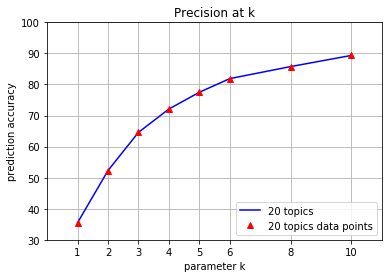

In [14]:
accuracy_scores_20topic={}
for i in [1,2,3,4,5,6,8,10]:
    accuracy, k = prediction_accuracy(test_author2doc, test_corpus_50_20, atmodel_standard, k=i)
    accuracy_scores_20topic[k] = accuracy
    
plot_accuracy(scores1=accuracy_scores_20topic, label1="20 topics")

This is a rather poor accuracy performace. We increase the number of topic to 100.

In [15]:
atmodel_100topics = train_model(train_corpus_50_20, train_author2doc, train_dictionary_50_20, num_topics=100, eval_every=0, iterations=50, passes=10)

05:31:51 INFO:Vocabulary consists of 3914 words.
05:31:51 INFO:using symmetric alpha at 0.01
05:31:51 INFO:using symmetric eta at 0.01
05:31:53 INFO:running online author-topic training, 100 topics, 50 authors, 10 passes over the supplied corpus of 2500 documents, updating model once every 2500 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
05:31:53 INFO:PROGRESS: pass 0, at document #2500/2500
05:31:53 DEBUG:performing inference on a chunk of 2500 documents
05:32:05 DEBUG:5/2500 documents converged within 50 iterations
05:32:05 DEBUG:updating topics
05:32:05 INFO:topic #18 (0.010): 0.007*"analyst" + 0.007*"business" + 0.005*"billion" + 0.005*"stock" + 0.005*"boeing" + 0.004*"quarter" + 0.004*"industry" + 0.004*"share" + 0.004*"shareholder" + 0.004*"sale"
05:32:05 INFO:topic #71 (0.010): 0.015*"fcc" + 0.015*"phone" + 0.011*"local" + 0.011*"carrier" + 0.010*"service" + 0.009*"rule" + 0.008*"court" + 0.008*"distance" + 0.008*"lo

05:32:41 INFO:topic #38 (0.010): 0.015*"analyst" + 0.014*"australian" + 0.013*"ltd" + 0.012*"share" + 0.011*"australia" + 0.011*"profit" + 0.010*"sydney" + 0.009*"group" + 0.009*"news" + 0.008*"corp"
05:32:41 INFO:topic #46 (0.010): 0.004*"hong" + 0.004*"kong" + 0.003*"china" + 0.002*"Hong Kong" + 0.002*"official" + 0.002*"hong_kong" + 0.002*"chinese" + 0.002*"united" + 0.002*"singapore" + 0.001*"month"
05:32:41 INFO:topic #97 (0.010): 0.021*"internet" + 0.017*"bank" + 0.008*"law" + 0.008*"court" + 0.008*"congress" + 0.007*"service" + 0.007*"credit" + 0.007*"allow" + 0.007*"bill" + 0.006*"policy"
05:32:41 INFO:topic #75 (0.010): 0.028*"bank" + 0.016*"japan" + 0.015*"billion" + 0.014*"yen" + 0.014*"financial" + 0.012*"loan" + 0.011*"japanese" + 0.010*"problem" + 0.010*"analyst" + 0.009*"firm"
05:32:41 INFO:topic #11 (0.010): 0.063*"gm" + 0.032*"plant" + 0.024*"strike" + 0.021*"automaker" + 0.021*"worker" + 0.017*"uaw" + 0.013*"truck" + 0.013*"local" + 0.013*"union" + 0.012*"chrysler"
05

-1.89056657258


Precision@k: top_n=1
Prediction accuracy: 0.5808
Precision@k: top_n=2
Prediction accuracy: 0.7472
Precision@k: top_n=3
Prediction accuracy: 0.8252
Precision@k: top_n=4
Prediction accuracy: 0.8732
Precision@k: top_n=5
Prediction accuracy: 0.8956
Precision@k: top_n=6
Prediction accuracy: 0.9072
Precision@k: top_n=8
Prediction accuracy: 0.9276
Precision@k: top_n=10
Prediction accuracy: 0.9412


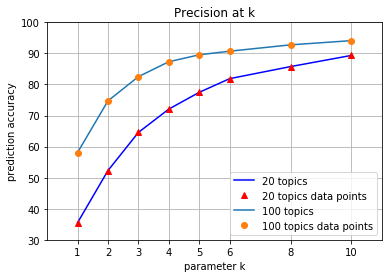

In [16]:
accuracy_scores_100topic={}
for i in [1,2,3,4,5,6,8,10]:
    accuracy, k = prediction_accuracy(test_author2doc, test_corpus_50_20, atmodel_100topics, k=i)
    accuracy_scores_100topic[k] = accuracy
    
plot_accuracy(scores1=accuracy_scores_20topic, label1="20 topics", scores2=accuracy_scores_100topic, label2="100 topics")

The 100-topic model is much more accurate than the 20-topic model. We continue to increase the topic until convergence.

In [17]:
atmodel_150topics = train_model(train_corpus_50_20, train_author2doc, train_dictionary_50_20, num_topics=150, eval_every=0, iterations=50, passes=15)

05:36:37 INFO:Vocabulary consists of 3914 words.
05:36:37 INFO:using symmetric alpha at 0.006666666666666667
05:36:37 INFO:using symmetric eta at 0.006666666666666667
05:36:40 INFO:running online author-topic training, 150 topics, 50 authors, 15 passes over the supplied corpus of 2500 documents, updating model once every 2500 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
05:36:40 INFO:PROGRESS: pass 0, at document #2500/2500
05:36:40 DEBUG:performing inference on a chunk of 2500 documents
05:36:55 DEBUG:15/2500 documents converged within 50 iterations
05:36:55 DEBUG:updating topics
05:36:56 INFO:topic #51 (0.007): 0.015*"profit" + 0.012*"price" + 0.012*"group" + 0.012*"analyst" + 0.009*"share" + 0.009*"steel" + 0.008*"tell" + 0.008*"australian" + 0.007*"month" + 0.007*"forecast"
05:36:56 INFO:topic #86 (0.007): 0.011*"china" + 0.008*"kong" + 0.007*"hong" + 0.007*"cargo" + 0.006*"hong_kong" + 0.006*"service" + 0.006*"Hong Kong

05:37:40 DEBUG:updating topics
05:37:40 INFO:topic #76 (0.007): 0.005*"china" + 0.004*"hong_kong" + 0.004*"price" + 0.003*"kong" + 0.003*"hong" + 0.003*"tonne" + 0.003*"world" + 0.003*"analyst" + 0.002*"chinese" + 0.002*"Hong Kong"
05:37:40 INFO:topic #31 (0.007): 0.008*"franc" + 0.007*"french" + 0.006*"china" + 0.006*"billion" + 0.005*"shanghai" + 0.005*"analyst" + 0.004*"share" + 0.004*"government" + 0.004*"plan" + 0.004*"exchange"
05:37:40 INFO:topic #140 (0.007): 0.026*"china" + 0.020*"beijing" + 0.016*"chinese" + 0.013*"official" + 0.010*"wang" + 0.006*"foreign" + 0.005*"right" + 0.005*"human" + 0.005*"washington" + 0.005*"state"
05:37:40 INFO:topic #46 (0.007): 0.004*"hong" + 0.004*"kong" + 0.003*"china" + 0.003*"Hong Kong" + 0.002*"official" + 0.002*"hong_kong" + 0.002*"chinese" + 0.002*"singapore" + 0.002*"united" + 0.002*"plan"
05:37:40 INFO:topic #148 (0.007): 0.001*"network" + 0.001*"analyst" + 0.001*"stock" + 0.001*"share" + 0.001*"price" + 0.001*"remote" + 0.001*"recent" +

05:38:19 INFO:topic #5 (0.007): 0.002*"china" + 0.001*"beijing" + 0.001*"chen" + 0.001*"official" + 0.001*"trade" + 0.001*"economic" + 0.001*"chinese" + 0.001*"party" + 0.001*"survey" + 0.001*"month"
05:38:19 INFO:topic #31 (0.007): 0.002*"franc" + 0.002*"french" + 0.002*"china" + 0.002*"billion" + 0.001*"shanghai" + 0.001*"analyst" + 0.001*"share" + 0.001*"government" + 0.001*"plan" + 0.001*"exchange"
05:38:19 INFO:topic diff=2.053082, rho=0.267261
05:38:19 INFO:PROGRESS: pass 13, at document #2500/2500
05:38:19 DEBUG:performing inference on a chunk of 2500 documents
05:38:26 DEBUG:2500/2500 documents converged within 50 iterations
05:38:26 DEBUG:updating topics
05:38:26 INFO:topic #3 (0.007): 0.000*"pound" + 0.000*"billion" + 0.000*"share" + 0.000*"group" + 0.000*"british" + 0.000*"deal" + 0.000*"bank" + 0.000*"sale" + 0.000*"mci" + 0.000*"service"
05:38:26 INFO:topic #42 (0.007): 0.000*"technology" + 0.000*"russia" + 0.000*"computer" + 0.000*"industry" + 0.000*"russian" + 0.000*"int

-1.90810257282


Precision@k: top_n=1
Prediction accuracy: 0.6004
Precision@k: top_n=2
Prediction accuracy: 0.7632
Precision@k: top_n=3
Prediction accuracy: 0.8452
Precision@k: top_n=4
Prediction accuracy: 0.8796
Precision@k: top_n=5
Prediction accuracy: 0.8988
Precision@k: top_n=6
Prediction accuracy: 0.914
Precision@k: top_n=8
Prediction accuracy: 0.9324
Precision@k: top_n=10
Prediction accuracy: 0.9464


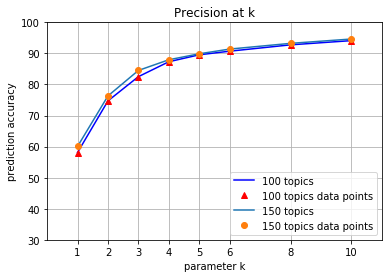

In [18]:
accuracy_scores_150topic={}
for i in [1,2,3,4,5,6,8,10]:
    accuracy, k = prediction_accuracy(test_author2doc, test_corpus_50_20, atmodel_150topics, k=i)
    accuracy_scores_150topic[k] = accuracy
    
plot_accuracy(scores1=accuracy_scores_100topic, label1="100 topics", scores2=accuracy_scores_150topic, label2="150 topics")

The 150-topic model is also slightly better, especially in the lower end of k. But we clearly see convergence. We try with 200 topic to be sure.

In [19]:
atmodel_200topics = train_model(train_corpus_50_20, train_author2doc, train_dictionary_50_20, num_topics=200, eval_every=0, iterations=50, passes=15)

05:43:01 INFO:Vocabulary consists of 3914 words.
05:43:01 INFO:using symmetric alpha at 0.005
05:43:01 INFO:using symmetric eta at 0.005
05:43:05 INFO:running online author-topic training, 200 topics, 50 authors, 15 passes over the supplied corpus of 2500 documents, updating model once every 2500 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
05:43:05 INFO:PROGRESS: pass 0, at document #2500/2500
05:43:05 DEBUG:performing inference on a chunk of 2500 documents
05:43:25 DEBUG:2/2500 documents converged within 50 iterations
05:43:25 DEBUG:updating topics
05:43:26 INFO:topic #198 (0.005): 0.006*"plant" + 0.006*"analyst" + 0.006*"gm" + 0.005*"sale" + 0.005*"group" + 0.005*"service" + 0.004*"share" + 0.004*"internet" + 0.004*"plan" + 0.004*"uaw"
05:43:26 INFO:topic #186 (0.005): 0.009*"pound" + 0.007*"quarter" + 0.007*"analyst" + 0.007*"share" + 0.006*"group" + 0.006*"business" + 0.005*"million_pound" + 0.005*"software" + 0.005*"sa

05:44:23 DEBUG:updating topics
05:44:24 INFO:topic #70 (0.005): 0.011*"stock" + 0.010*"shanghai" + 0.008*"share" + 0.008*"exchange" + 0.007*"trading" + 0.007*"china" + 0.007*"bank" + 0.006*"future" + 0.006*"beijing" + 0.005*"index"
05:44:24 INFO:topic #177 (0.005): 0.011*"investment" + 0.010*"pound" + 0.010*"group" + 0.008*"cable" + 0.008*"british" + 0.007*"fleming" + 0.007*"management" + 0.007*"share" + 0.006*"fund" + 0.006*"merger"
05:44:24 INFO:topic #37 (0.005): 0.015*"bank" + 0.012*"czech" + 0.008*"crown" + 0.006*"prague" + 0.005*"foreign" + 0.005*"billion" + 0.004*"state" + 0.004*"deficit" + 0.004*"communist" + 0.004*"central"
05:44:24 INFO:topic #56 (0.005): 0.032*"kong" + 0.031*"hong" + 0.031*"hong_kong" + 0.022*"Hong Kong" + 0.016*"china" + 0.007*"fund" + 0.007*"Hong Kong's" + 0.006*"chinese" + 0.005*"tung" + 0.005*"british"
05:44:24 INFO:topic #32 (0.005): 0.004*"china" + 0.003*"beijing" + 0.002*"taiwan" + 0.002*"bre" + 0.002*"bre_x" + 0.002*"share" + 0.002*"x" + 0.002*"chine

05:45:18 INFO:topic #130 (0.005): 0.019*"mci" + 0.012*"analyst" + 0.011*"service" + 0.011*"share" + 0.010*"long" + 0.010*"billion" + 0.009*"long_distance" + 0.009*"distance" + 0.009*"corp" + 0.008*"deal"
05:45:18 INFO:topic #151 (0.005): 0.012*"billion" + 0.008*"sale" + 0.007*"computer" + 0.007*"industry" + 0.006*"good" + 0.006*"analyst" + 0.006*"product" + 0.006*"quarter" + 0.005*"forecast" + 0.005*"internet"
05:45:18 INFO:topic diff=2.611657, rho=0.267261
05:45:18 INFO:PROGRESS: pass 13, at document #2500/2500
05:45:18 DEBUG:performing inference on a chunk of 2500 documents
05:45:28 DEBUG:2500/2500 documents converged within 50 iterations
05:45:28 DEBUG:updating topics
05:45:28 INFO:topic #74 (0.005): 0.036*"china" + 0.029*"tonne" + 0.021*"chinese" + 0.021*"trader" + 0.018*"price" + 0.014*"import" + 0.013*"source" + 0.011*"copper" + 0.010*"official" + 0.010*"million_tonne"
05:45:28 INFO:topic #138 (0.005): 0.000*"china" + 0.000*"beijing" + 0.000*"share" + 0.000*"news" + 0.000*"states

-1.93149366596


Precision@k: top_n=1
Prediction accuracy: 0.6232
Precision@k: top_n=2
Prediction accuracy: 0.7664
Precision@k: top_n=3
Prediction accuracy: 0.8456
Precision@k: top_n=4
Prediction accuracy: 0.8816
Precision@k: top_n=5
Prediction accuracy: 0.9032
Precision@k: top_n=6
Prediction accuracy: 0.9164
Precision@k: top_n=8
Prediction accuracy: 0.9368
Precision@k: top_n=10
Prediction accuracy: 0.9464


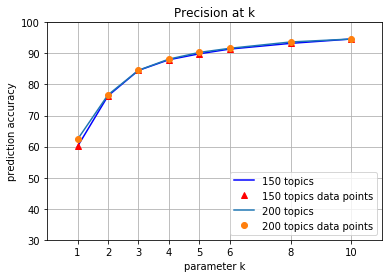

In [20]:
accuracy_scores_200topic={}
for i in [1,2,3,4,5,6,8,10]:
    accuracy, k = prediction_accuracy(test_author2doc, test_corpus_50_20, atmodel_200topics, k=i)
    accuracy_scores_200topic[k] = accuracy
    
plot_accuracy(scores1=accuracy_scores_150topic, label1="150 topics", scores2=accuracy_scores_200topic, label2="200 topics")

The 200-topic seems to be performing a bit better for lower k, might be due to a slight overrepresentation with high topic number. So let us stop here with the topic number increase and focus some more on the dictionary. We choose either one of the models.
Currently we are filtering out tokens, that appear in more 50% of all documents and no more than 20 times overall, which drastically decreaces the size of our dictionary. 
We know about this dataset, that the underlying topic are not so diverse and are structed around corporate/industrial topic class. Thus it makes sense to increase the dictionary by filtering less tokens.

We set the parameters set max_freq=25%, min_wordcount=10

In [30]:
train_corpus_25_10, train_dictionary_25_10 = create_corpus_dictionary(train_docs, 0.25, 10)

06:18:50 INFO:adding document #0 to Dictionary(0 unique tokens: [])
06:18:51 INFO:built Dictionary(46905 unique tokens: ['$83.4 million', 'boarder', '$2.72 billion', 'checking', 'suzuki']...) from 2500 documents (total 786032 corpus positions)
06:18:51 INFO:discarding 40690 tokens: [('$15', 3), ('$17.25', 1), ('$380 million', 2), ('12.5 cents', 7), ('Big B', 3), ('Big B Inc.', 2), ("Big B's", 3), ('Big B. I', 1), ('Dwayne Hoven', 1), ('Eckerd Corp.', 1)]...
06:18:51 INFO:keeping 6215 tokens which were in no less than 10 and no more than 625 (=25.0%) documents
06:18:51 DEBUG:rebuilding dictionary, shrinking gaps
06:18:51 INFO:resulting dictionary: Dictionary(6215 unique tokens: ['offshoot', 'shore', 'loss', 'merger', 'disappointing']...)


In [31]:
test_corpus_25_10 = create_test_corpus(train_dictionary_25_10, test_docs)

In [32]:
print('Number of unique tokens: %d' % len(train_dictionary_25_10))

Number of unique tokens: 6215


We now have now nearly doubled the tokens. Let's train and evaluate.

In [33]:
atmodel_150topics_25_10 = train_model(train_corpus_25_10, train_author2doc, train_dictionary_25_10, num_topics=150, eval_every=0, iterations=50, passes=15)

06:18:53 INFO:Vocabulary consists of 6215 words.
06:18:53 INFO:using symmetric alpha at 0.006666666666666667
06:18:53 INFO:using symmetric eta at 0.006666666666666667
06:18:57 INFO:running online author-topic training, 150 topics, 50 authors, 15 passes over the supplied corpus of 2500 documents, updating model once every 2500 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
06:18:57 INFO:PROGRESS: pass 0, at document #2500/2500
06:18:57 DEBUG:performing inference on a chunk of 2500 documents
06:19:11 DEBUG:17/2500 documents converged within 50 iterations
06:19:11 DEBUG:updating topics
06:19:12 INFO:topic #141 (0.007): 0.031*"gm" + 0.016*"plant" + 0.011*"worker" + 0.010*"uaw" + 0.009*"strike" + 0.009*"truck" + 0.008*"local" + 0.007*"automaker" + 0.006*"part" + 0.005*"contract"
06:19:12 INFO:topic #105 (0.007): 0.013*"china" + 0.010*"tonne" + 0.009*"chinese" + 0.008*"trader" + 0.007*"copper" + 0.007*"product" + 0.005*"drug" + 0.00

06:19:51 DEBUG:updating topics
06:19:52 INFO:topic #44 (0.007): 0.007*"internet" + 0.004*"committee" + 0.003*"proposal" + 0.003*"address" + 0.003*"trade" + 0.003*"china" + 0.003*"congress" + 0.002*"member" + 0.002*"financial" + 0.002*"name"
06:19:52 INFO:topic #131 (0.007): 0.009*"bank" + 0.008*"internet" + 0.007*"court" + 0.005*"exchange" + 0.004*"foreign" + 0.004*"currency" + 0.004*"trading" + 0.004*"policy" + 0.003*"law" + 0.003*"security"
06:19:52 INFO:topic #112 (0.007): 0.001*"bank" + 0.001*"russia" + 0.001*"x" + 0.001*"diamond" + 0.001*"bre" + 0.001*"bre_x" + 0.001*"canada" + 0.001*"export" + 0.001*"canadian" + 0.001*"Bre-X"
06:19:52 INFO:topic #49 (0.007): 0.008*"bid" + 0.008*"penny" + 0.005*"pound" + 0.004*"northern" + 0.004*"electric" + 0.003*"midlands" + 0.003*"offer" + 0.003*"sector" + 0.003*"electricity" + 0.003*"east"
06:19:52 INFO:topic #61 (0.007): 0.008*"china" + 0.008*"tibet" + 0.005*"chinese" + 0.005*"beijing" + 0.005*"foreign" + 0.004*"wang" + 0.004*"hong_kong" + 0.

06:20:30 INFO:topic #9 (0.007): 0.025*"shanghai" + 0.022*"china" + 0.018*"bank" + 0.014*"b" + 0.014*"foreign" + 0.011*"investor" + 0.011*"exchange" + 0.011*"b_share" + 0.010*"beijing" + 0.010*"shenzhen"
06:20:30 INFO:topic #24 (0.007): 0.024*"czech" + 0.011*"crown" + 0.011*"bank" + 0.010*"prague" + 0.009*"klaus" + 0.008*"party" + 0.006*"havel" + 0.006*"foreign" + 0.006*"country" + 0.006*"election"
06:20:30 INFO:topic diff=1.660230, rho=0.267261
06:20:30 INFO:PROGRESS: pass 13, at document #2500/2500
06:20:30 DEBUG:performing inference on a chunk of 2500 documents
06:20:37 DEBUG:2500/2500 documents converged within 50 iterations
06:20:37 DEBUG:updating topics
06:20:38 INFO:topic #108 (0.007): 0.003*"gm" + 0.002*"computer" + 0.002*"quarter" + 0.002*"ibm" + 0.002*"car" + 0.002*"technology" + 0.002*"france" + 0.002*"thomson" + 0.002*"plant" + 0.002*"service"
06:20:38 INFO:topic #116 (0.007): 0.000*"china" + 0.000*"bank" + 0.000*"tonne" + 0.000*"problem" + 0.000*"hong_kong" + 0.000*"trader"

-2.83261288295


Precision@k: top_n=1
Prediction accuracy: 0.6176
Precision@k: top_n=2
Prediction accuracy: 0.7712
Precision@k: top_n=3
Prediction accuracy: 0.8268
Precision@k: top_n=4
Prediction accuracy: 0.8656
Precision@k: top_n=5
Prediction accuracy: 0.8916
Precision@k: top_n=6
Prediction accuracy: 0.9112
Precision@k: top_n=8
Prediction accuracy: 0.9308
Precision@k: top_n=10
Prediction accuracy: 0.9408


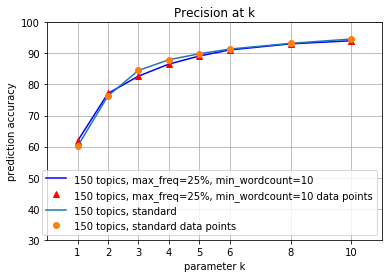

In [35]:
accuracy_scores_150topic_25_10={}
for i in [1,2,3,4,5,6,8,10]:
    accuracy, k = prediction_accuracy(test_author2doc, test_corpus_25_10, atmodel_150topics_25_10, k=i)
    accuracy_scores_150topic_25_10[k] = accuracy
    
plot_accuracy(scores1=accuracy_scores_150topic_25_10, label1="150 topics, max_freq=25%, min_wordcount=10", scores2=accuracy_scores_150topic, label2="150 topics, standard")

The results seem rather ambigious and do not show a clear trend. Which is why we would stop here for the iterations.